In [1]:
#import the needed Libraries

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from PIL import Image
import pandas as pd

from IPython import display
import cv2
import pickle

/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
#Load the dataset

filelist = glob.glob('./new_images/*.jpg')

lol = []
for count,fname in enumerate(filelist):
        if count % 5 == 0:
            arr = np.array(Image.open(fname))
            lol.append(arr)
    
x = np.array(lol)  
    
#x = np.array([np.array(Image.open(fname)) for fname in filelist])

In [3]:
x.shape

(18232, 80, 60, 3)

In [4]:
#randomly sample here!
np.random.shuffle(x)
train_images, test_images = np.split(x,[17000])    #18000 is the train_size

In [5]:
#change the number of channels to 1.

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255.
test_images /= 255.

In [6]:
#We create both the train and test dataset
batch_size = 64
train_size = len(train_images)
test_size = len(x) - train_size

#convert to tensorflow type tf.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [7]:
train_dataset

<BatchDataset shapes: (None, 80, 60, 3), types: tf.float32>

In [8]:
#create a write
writer = tf.summary.create_file_writer('./new_loss')

In [12]:
#The Convolutional Variational Auto-Encoder Proper. 
#Define the network class

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):   #latent_dim is the dimensional of the latent space
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(80, 60, 3)),   #Note Input Image Size
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=128, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=40*30*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(40,30, 32)), #Note the strides formula!
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=128,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=3, kernel_size= 3, strides=(1, 1), padding="SAME", activation='sigmoid'),
            ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):   #encode the images into the latent space
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
    #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it 
    #by the latent distribution's variance 'rho'.

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    kl_tolerance = 0.5
    #import pdb; pdb.set_trace()
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1, 2, 3]))
    kl_loss = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar),axis=1)
    kl_loss = tf.reduce_mean(tf.maximum(kl_loss, kl_tolerance * latent_dim))
    loss_sum = reconstruction_loss + kl_loss
    
    with writer.as_default():
        tf.summary.scalar('Graph of' + '_reconstruction_loss', reconstruction_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_kl_loss', kl_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_loss_sum',loss_sum, step=epoch)
        writer.flush()
    return loss_sum, reconstruction_loss, kl_loss

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, r_loss, kl_loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return r_loss, kl_loss

In [14]:
epochs = 100
latent_dim = 128
num_examples_to_generate = 12

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [12]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(16,16))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('./images/soccer/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [13]:
def test_image(latent_dim,test_img):
    test_img = test_img.reshape(1,320,240,3)   #Note the Image size here
    model = CVAE(latent_dim)
    encod, logvar = model.encode(test_img)
    repar = model.reparameterize(encod, logvar)
    img = model.decode(repar)
    img *= 255.
    img = np.squeeze(img)
    return plt.imshow(img)

Epoch: 2, Test set LOSS_sum: 296.2442932128906, reconstruction_loss: 279.4052734375, kl_loss: 16.839017868041992,time elapse for current epoch 32.866774797439575


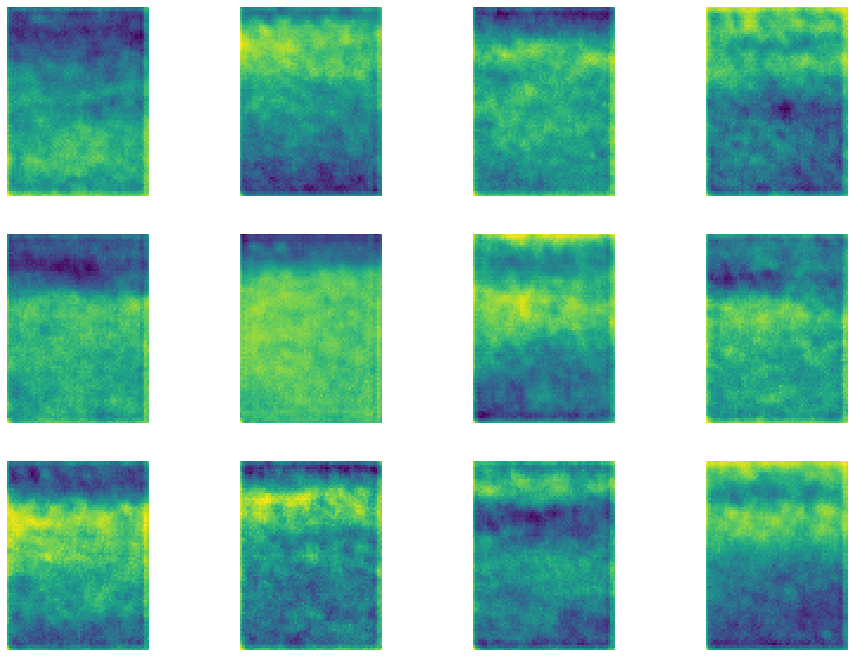

In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)
df = pd.DataFrame()

losslist = []
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        r_loss, kl_loss = compute_apply_gradients(model, train_x, optimizer)
        #print(r_loss, kl_loss)
    end_time = time.time()

    if epoch % 1 == 0:
        #loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss_sum, rec_loss, kl_loss = compute_loss(model, test_x)
        losslist.append({'loss_sum':loss_sum.numpy(),'reconstruction_loss':rec_loss.numpy(),'kl_loss':kl_loss.numpy()})#append loss to list
        
        display.clear_output(wait=False)
        
        df = pd.DataFrame(losslist, ignore_index=True)  #append the dictionary to the dataframe
        df.to_csv('loss.csv')    #correct this

        print('Epoch: {}, Test set LOSS_sum: {}, reconstruction_loss: {}, kl_loss: {},'
              'time elapse for current epoch {}'.format(epoch,
                                                    loss_sum,rec_loss,kl_loss,
                                                    end_time - start_time))
    model.save_weights('my_model_weights.h5')
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

In [ ]:
#save model to pickle
model.save_weights('my_model_weights.h5')  #save the model

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('./images/soccer/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

In [ ]:
#Generate a GIF of all the saved Images

anim_file = './Gifs/soccer.gif'   #change Gif name

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./images/soccer/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)

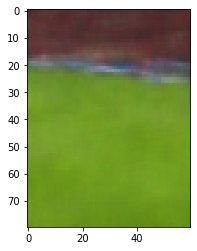

In [15]:
add = 'chebay0626.jpg'    
test_inputs = np.array(Image.open(add))   
test_inputs = test_inputs.astype('float32')

test_inputs /= 255.

test_inputs = test_inputs.reshape(1,80,60,3)

#from tf.keras.models import load_model

def check_image(test_inputs,latent_dim):
    model.load_weights('my_model_weights.h5')
    loaded_model = model
    encod, logvar = loaded_model.encode(test_inputs)
    repar = loaded_model.reparameterize(encod, logvar)
    img = loaded_model.decode(repar)
    #loss_sum, kl_loss, recon_loss = compute_loss(loaded_model, test_inputs)
    #print(loss_sum, kl_loss, recon_loss)
    img = np.squeeze(img)
    return plt.imshow(img)

img = check_image(test_inputs,10)

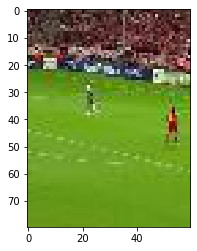

In [16]:
add ='chebay0626.jpg'   
check_inputs = np.array(Image.open(add)) 
plt.imshow(check_inputs)

In [ ]:
test_inputs.shape

In [2]:
df = pd.read_csv('loss.csv',encoding = 'unicode_escape')

In [7]:
df = df.tail(300)

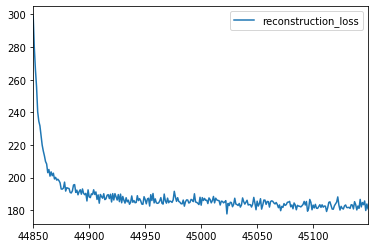

In [8]:
df.plot(y='reconstruction_loss')

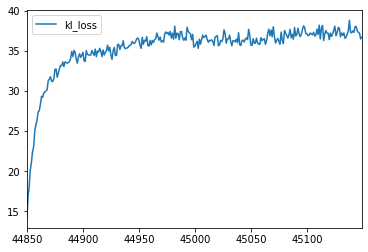

In [9]:
#import matplotlib.pyploy as plt

df.plot(y='kl_loss')

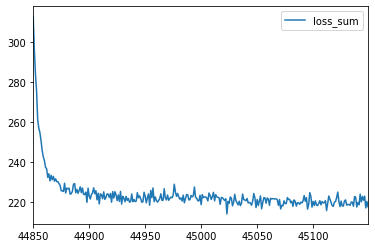

In [10]:
df.plot(y='loss_sum')

In [3]:
!aws s3 cp 's3://dsr-project/Activity-Detection-files/new_loss.csv' './new_loss.csv'

download: s3://dsr-project/Activity-Detection-files/new_loss.csv to ./new_loss.csv


In [1]:
!pwd

/Users/admin/DSR-Project/cloud-Activity-Detection-files
